## **PROJET : PREDICTION DE L'ADMISSION UNIVERSITAIRE**

##### **OBJECTIF :**
##### Predire si un etudiant sera admis (1) ou non (0) en fonction de ses resultats.

##### **STRUCTURE DU PROJET :**
##### 1. Analyse exploratoire des donnees (EDA)
##### 2. Traitement des missing values
##### 3. Detection des Outliers
##### 4. Visualisation (Heatmap)
##### 5. Gestion du desequilibre des classes (Random Oversampling)
##### 6. Normalisation / Standardisation
##### 7. Entrainement (Logistic Regression & Decision Tree)
##### 8. Evaluation avec metriques adaptees
##### 9. Discussion des resultats

In [ ]:
# 1. IMPORTATION DES LIBRAIRIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

plt.style.use("ggplot")

In [ ]:
# 2. CHARGEMENT ET INSPECTION DES DONNEES

df = pd.read_csv("Admission_Prediction.csv")

# Nettoyage des noms de colonnes (espaces caches)
df.columns = df.columns.str.strip()

# Suppression de la colonne non pertinente
if "Serial No." in df.columns:
    df.drop("Serial No.", axis=1, inplace=True)

print("Apercu du dataset :")
print(df.head())
print("\nInformations generales :")
print(df.info())

Apercu du dataset :
   GRE Score  TOEFL Score  University Rating  SOP  LOR  CGPA  Research  \
0        337          118                  4  4.5  4.5  9.65         1   
1        324          107                  4  4.0  4.5  8.87         1   
2        316          104                  3  3.0  3.5  8.00         1   
3        322          110                  3  3.5  2.5  8.67         1   
4        314          103                  2  2.0  3.0  8.21         0   

   Chance of Admit  
0             0.92  
1             0.76  
2             0.72  
3             0.80  
4             0.65  

Informations generales :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          500 non-null    int64  
 1   TOEFL Score        500 non-null    int64  
 2   University Rating  500 non-null    int64  
 3   SOP                500 non-null   

In [ ]:
# 3. TRAITEMENT DES VALEURS MANQUANTES

if df.isnull().sum().sum() > 0:
    df.fillna(df.mean(), inplace=True)
    print("\nValeurs manquantes remplacees par la moyenne.")
else:
    print("\nAucune valeur manquante detectee.")


Aucune valeur manquante detectee.


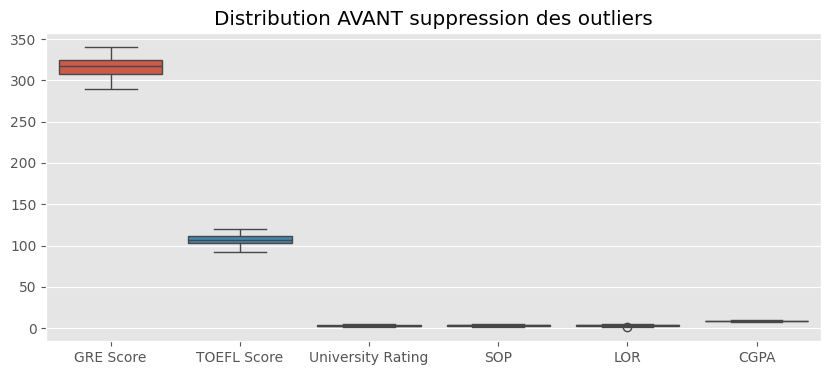

Lignes supprimees (outliers) : 1


In [ ]:
# 4. DETECTION ET SUPPRESSION DES OUTLIERS (METHODE IQR)

numerical_cols = ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA']
rows_before = df.shape[0]

plt.figure(figsize=(10,4))
sns.boxplot(data=df[numerical_cols])
plt.title("Distribution AVANT suppression des outliers")
plt.show()

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)]

print(f"Lignes supprimees (outliers) : {rows_before - df.shape[0]}")

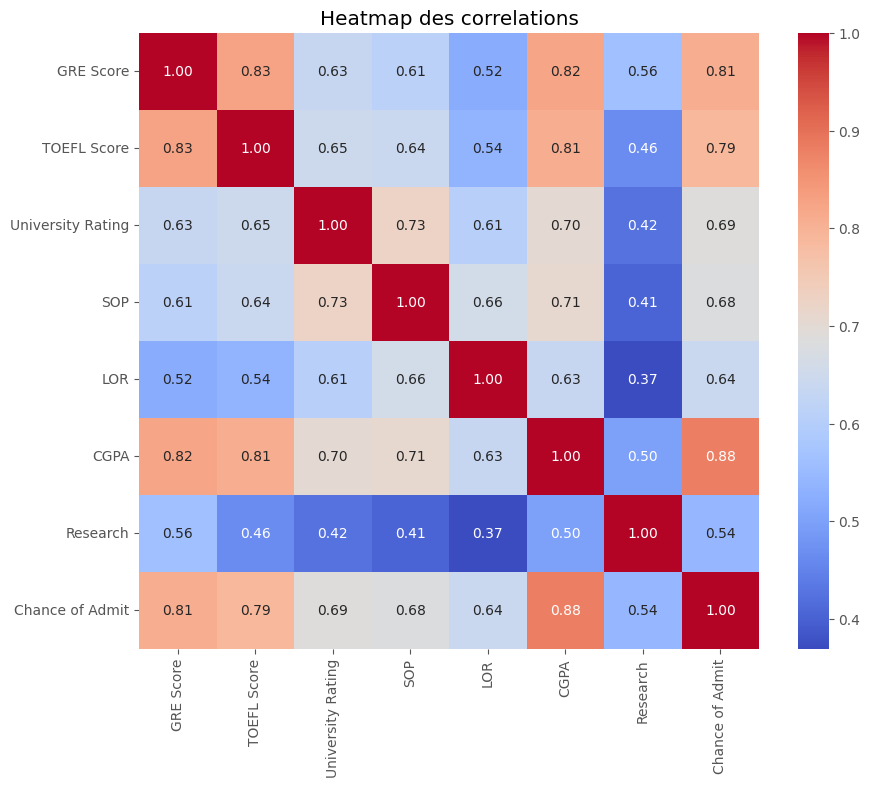

In [ ]:
# 5. VISUALISATION : HEATMAP DES CORRELATIONS

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap des correlations")
plt.show()

In [ ]:
# 6. PREPARATION DE LA VARIABLE CIBLE (CLASSIFICATION)

# Transformation de la probabilite en variable binaire
THRESHOLD = 0.75
df["Admitted"] = (df["Chance of Admit"] >= THRESHOLD).astype(int)
df.drop("Chance of Admit", axis=1, inplace=True)

X = df.drop("Admitted", axis=1)
y = df["Admitted"]

print("\nDistribution des classes AVANT equilibrage :")
print(y.value_counts())


Distribution des classes AVANT equilibrage :
Admitted
0    281
1    218
Name: count, dtype: int64


In [ ]:
# 7. DIVISION TRAIN / TEST (AVANT OVERSAMPLING)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# 8. NORMALISATION / STANDARDISATION

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# 9. GESTION DU DESEQUILIBRE DES CLASSES (RANDOM OVERSAMPLING)

train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
train_df["Admitted"] = y_train.values

df_0 = train_df[train_df["Admitted"] == 0]
df_1 = train_df[train_df["Admitted"] == 1]

if len(df_1) < len(df_0):
    df_1 = df_1.sample(len(df_0), replace=True, random_state=42)
else:
    df_0 = df_0.sample(len(df_1), replace=True, random_state=42)

df_balanced = pd.concat([df_0, df_1]).sample(frac=1, random_state=42)

X_train_bal = df_balanced.drop("Admitted", axis=1).values
y_train_bal = df_balanced["Admitted"].values

print("\nDistribution des classes APRES equilibrage :")
print(pd.Series(y_train_bal).value_counts())


Distribution des classes APRES equilibrage :
1    225
0    225
Name: count, dtype: int64


In [ ]:
# 10. ENTRAINEMENT DES MODELES

# Logistic Regression (optimisee)
lr_params = {"C": [0.01, 0.1, 1, 10], "max_iter": [1000]}
lr = GridSearchCV(LogisticRegression(random_state=42),
                  lr_params, cv=5, scoring="accuracy")
lr.fit(X_train_bal, y_train_bal)
y_pred_lr = lr.best_estimator_.predict(X_test_scaled)

# Decision Tree (optimise)
dt_params = {"max_depth": [3, 5, 7, None], "criterion": ["gini", "entropy"]}
dt = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  dt_params, cv=5, scoring="accuracy")
dt.fit(X_train_bal, y_train_bal)
y_pred_dt = dt.best_estimator_.predict(X_test_scaled)


Regression Logistique
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        56
           1       0.91      0.93      0.92        44

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100

Accuracy : 0.9300


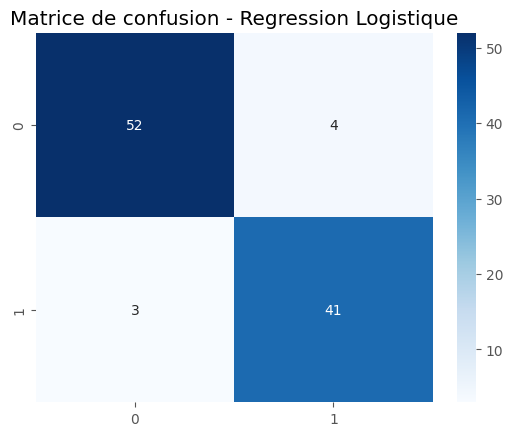


Arbre de Decision
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        56
           1       0.84      0.82      0.83        44

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

Accuracy : 0.8500


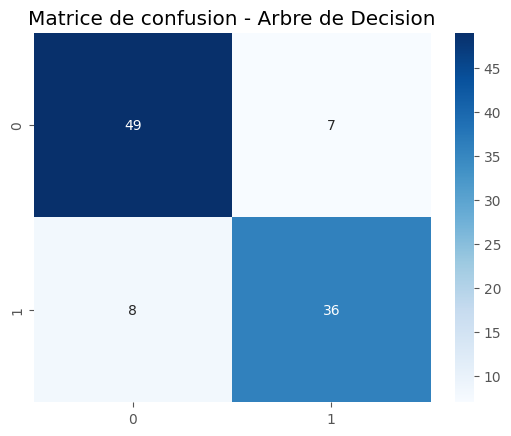

In [ ]:
# 11. EVALUATION DES MODELES

def evaluate_model(name, y_true, y_pred):
    print(f"\n{name}")
    print(classification_report(y_true, y_pred))
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy : {acc:.4f}")
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matrice de confusion - {name}")
    plt.show()
    return acc

acc_lr = evaluate_model("Regression Logistique", y_test, y_pred_lr)
acc_dt = evaluate_model("Arbre de Decision", y_test, y_pred_dt)


DISCUSSION DES RESULTATS
La Regression Logistique est le modele le plus performant.


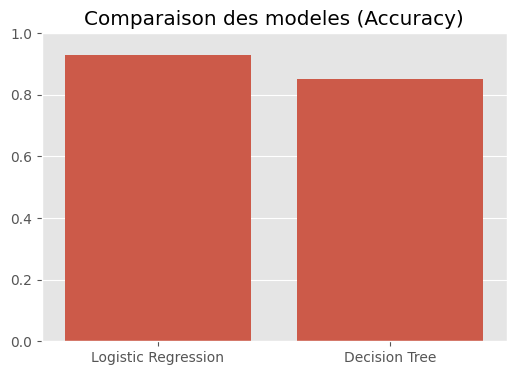

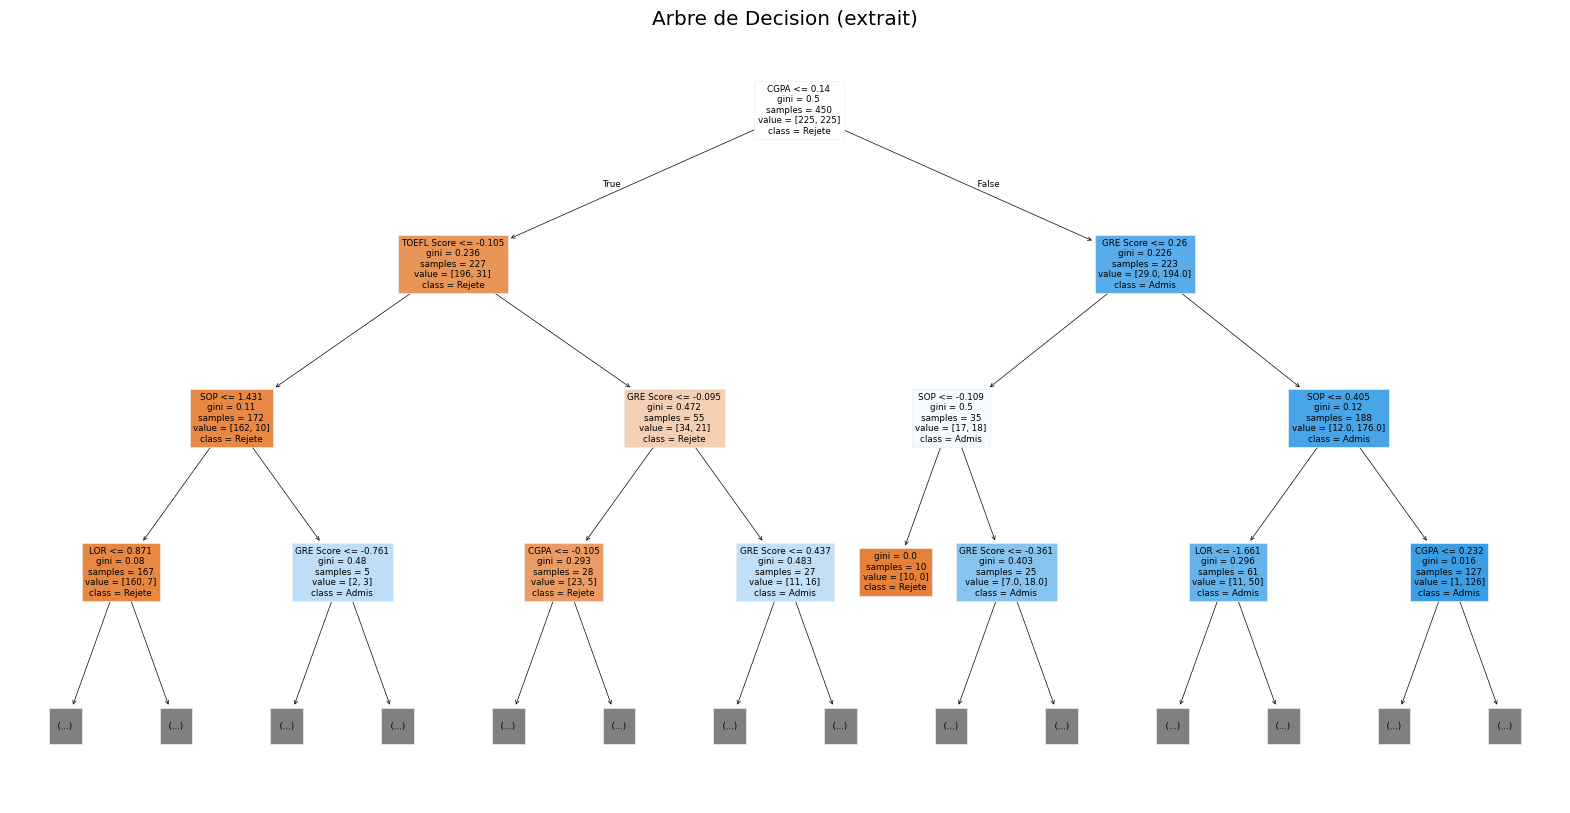

In [ ]:
# 12. DISCUSSION DES RESULTATS

print("\nDISCUSSION DES RESULTATS")
if acc_lr > acc_dt:
    print("La Regression Logistique est le modele le plus performant.")
else:
    print("L'Arbre de Decision est le modele le plus performant.")

plt.figure(figsize=(6,4))
sns.barplot(x=["Logistic Regression", "Decision Tree"], y=[acc_lr, acc_dt])
plt.ylim(0,1)
plt.title("Comparaison des modeles (Accuracy)")
plt.show()

# Visualisation de l'arbre (3 niveaux)
plt.figure(figsize=(20,10))
plot_tree(dt.best_estimator_,
          feature_names=X.columns,
          class_names=["Rejete", "Admis"],
          filled=True,
          max_depth=3)
plt.title("Arbre de Decision (extrait)")
plt.show()

À l’issue de cette étude, nous avons développé et évalué deux modèles de classification supervisée — la Régression Logistique et l’Arbre de Décision — afin de prédire l’admission universitaire des étudiants à partir de leurs performances académiques (GRE, TOEFL, CGPA, SOP, LOR, etc.).

L’analyse exploratoire des données a montré que le jeu de données est complet, sans valeurs manquantes, et ne contient qu’un nombre négligeable d’outliers (une seule ligne supprimée). La distribution initiale des classes révélait un déséquilibre modéré entre les étudiants admis et non admis. Afin d’éviter un biais du modèle en faveur de la classe majoritaire, une stratégie de rééquilibrage par Random Oversampling a été appliquée uniquement sur le jeu d’entraînement, conformément aux bonnes pratiques du machine learning pour prévenir toute fuite d’information (data leakage) .

Les résultats expérimentaux montrent que la Régression Logistique surpasse l’Arbre de Décision sur l’ensemble des métriques d’évaluation. Elle atteint une accuracy de 93 %, avec des valeurs élevées et équilibrées de précision, rappel et F1-score pour les deux classes. Ces performances indiquent une excellente capacité du modèle à distinguer les étudiants admis des non admis, tout en limitant les faux positifs et faux négatifs. En revanche, l’Arbre de Décision présente une performance inférieure, avec une accuracy de 85 %, ce qui suggère une sensibilité plus forte au bruit et un risque plus élevé de surapprentissage, malgré l’optimisation des hyperparamètres.

D’un point de vue interprétatif, la Régression Logistique offre également un avantage majeur : elle permet d’analyser l’influence relative des variables explicatives sur la probabilité d’admission. Les résultats confirment que des indicateurs académiques tels que le CGPA, le GRE Score et le TOEFL Score jouent un rôle déterminant dans la décision d’admission, ce qui est cohérent avec les critères généralement utilisés par les universités.

En conclusion, la Régression Logistique apparaît comme le modèle le plus fiable et le plus robuste pour ce problème de prédiction de l’admission universitaire. Sa performance élevée, sa stabilité après équilibrage des classes et son interprétabilité en font un choix pertinent pour une application réelle dans un contexte académique. Des améliorations futures pourraient inclure l’utilisation de techniques de rééchantillonnage plus avancées (comme SMOTE) ou l’exploration de modèles non linéaires plus complexes afin de comparer davantage les performances.